In [ ]:
# scratch model
# transfer learning 1
# transfer learning 2

In [2]:
!pip install split-folders

In [1]:
import os 
import logging
import optuna

import tensorflow
import matplotlib.pyplot as plt 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



print(tensorflow.__version__)

2025-06-26 12:24:28.630268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750940668.846012      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750940668.907138      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [3]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/profile/data", output="/kaggle/working/main",seed=1337, ratio=(.7, .2, .1))

Copying files: 5194 files [00:23, 224.55 files/s]


In [4]:
# creating a pipeline to generate the data : data generator

train = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/train",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)
val = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/val",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)
test = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/test",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)

Found 3635 files belonging to 5 classes.


I0000 00:00:1750940740.499234      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1038 files belonging to 5 classes.
Found 521 files belonging to 5 classes.


# vgg16 with optuna 

In [5]:
optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler())

In [6]:
train = train.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(tensorflow.data.AUTOTUNE)
val = val.map(lambda x, y: (x / 255.0, y)).cache().prefetch(tensorflow.data.AUTOTUNE)


In [7]:

def objective(trial):
    
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "parametric relu"])
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_categorical("n_units", [64, 128, 256, 512])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd", "adagrad"])

    base_model = keras.applications.VGG16(
        include_top=False, weights='imagenet', input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())

    for i in range(n_layers):
        model.add(layers.Dense(n_units))
        if activation == "parametric relu":
            model.add(layers.PReLU())
        else:
            model.add(layers.Activation(activation))
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(17, activation="softmax"))

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    checkpoint_path = f"vgg_checkpoints/vgg_trial_{trial.number}.keras"
    os.makedirs("vgg_checkpoints", exist_ok=True)

    callbacks = [
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode="min",
            verbose=0
        ),
        EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
    ]

    history = model.fit(
        train,
        validation_data=val,
        epochs=50,
        batch_size=256,
        callbacks=callbacks,
        verbose=1
    )

    val_loss = history.history["val_loss"][-1]
    trial.set_user_attr("val_accuracy", history.history.get("val_accuracy", [None])[-1])
    trial.set_user_attr("history", history.history)
    
    return val_loss


In [8]:


# Logging and study setup
optuna.logging.get_logger("optuna").addHandler(logging.FileHandler("optuna_vgg16_1.log"))

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.RandomSampler(),
    study_name="vgg16_tuning"
)

study.optimize(objective, n_trials=5,show_progress_bar=True)



[I 2025-06-26 12:26:27,476] A new study created in memory with name: vgg16_tuning
A new study created in memory with name: vgg16_tuning


  0%|          | 0/5 [00:00<?, ?it/s]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1750940794.179229     108 service.cc:148] XLA service 0x7cef8400d5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750940794.179844     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750940794.509949     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/114 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.1094 - loss: 2.9948  

I0000 00:00:1750940802.796459     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


114/114 ━━━━━━━━━━━━━━━━━━━━ 34s 173ms/step - accuracy: 0.2349 - loss: 2.0076 - val_accuracy: 0.3863 - val_loss: 1.4810
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.3329 - loss: 1.5429 - val_accuracy: 0.4133 - val_loss: 1.3893
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.4232 - loss: 1.4210 - val_accuracy: 0.6445 - val_loss: 1.2776
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.5021 - loss: 1.3282 - val_accuracy: 0.7495 - val_loss: 1.1853
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.5832 - loss: 1.2166 - val_accuracy: 0.7331 - val_loss: 1.0991
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6344 - loss: 1.1368 - val_accuracy: 0.6513 - val_loss: 1.0264
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6754 - loss: 1.0350 - val_accuracy: 0.8372 - val_loss: 0.9157
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.7145 - loss: 0.9560 - val_accura

Trial 0 finished with value: 0.1700638085603714 and parameters: {'activation': 'parametric relu', 'n_layers': 1, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.1700638085603714.


[I 2025-06-26 12:35:26,175] Trial 0 finished with value: 0.1700638085603714 and parameters: {'activation': 'parametric relu', 'n_layers': 1, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.1700638085603714.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.2127 - loss: 2.2314 - val_accuracy: 0.6724 - val_loss: 1.3970
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.3880 - loss: 1.5205 - val_accuracy: 0.8410 - val_loss: 0.9426
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.5822 - loss: 1.0998 - val_accuracy: 0.9133 - val_loss: 0.5366
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.7258 - loss: 0.7476 - val_accuracy: 0.9470 - val_loss: 0.2986
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.8009 - loss: 0.5434 - val_accuracy: 0.9846 - val_loss: 0.2121
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.8558 - loss: 0.4236 - val_accuracy: 0.9692 - val_loss: 

Trial 1 finished with value: 0.003958994057029486 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 64, 'optimizer': 'adam'}. Best is trial 1 with value: 0.003958994057029486.


[I 2025-06-26 12:44:04,506] Trial 1 finished with value: 0.003958994057029486 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 64, 'optimizer': 'adam'}. Best is trial 1 with value: 0.003958994057029486.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.2143 - loss: 1.9921 - val_accuracy: 0.4017 - val_loss: 1.4290
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.3540 - loss: 1.4907 - val_accuracy: 0.5983 - val_loss: 1.2805
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.5056 - loss: 1.3083 - val_accuracy: 0.7033 - val_loss: 1.1407
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6199 - loss: 1.1756 - val_accuracy: 0.7842 - val_loss: 1.0340
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.7033 - loss: 1.0308 - val_accuracy: 0.7929 - val_loss: 0.9041
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.7482 - loss: 0.9309 - val_accuracy: 0.8198 - val_loss: 0.7974


Trial 2 finished with value: 0.1407472789287567 and parameters: {'activation': 'tanh', 'n_layers': 1, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.003958994057029486.


[I 2025-06-26 12:52:43,995] Trial 2 finished with value: 0.1407472789287567 and parameters: {'activation': 'tanh', 'n_layers': 1, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.003958994057029486.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.1585 - loss: 2.5235 - val_accuracy: 0.3025 - val_loss: 1.7670
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2456 - loss: 1.9321 - val_accuracy: 0.4027 - val_loss: 1.6398
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2433 - loss: 1.8318 - val_accuracy: 0.4518 - val_loss: 1.5741
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.2648 - loss: 1.7391 - val_accuracy: 0.4692 - val_loss: 1.5272
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2810 - loss: 1.6842 - val_accuracy: 0.4846 - val_loss: 1.4877
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.3034 - loss: 1.6424 - val_accuracy: 0.5703 - val_loss: 1.4519
Ep

Trial 3 finished with value: 0.7578622102737427 and parameters: {'activation': 'tanh', 'n_layers': 1, 'n_units': 128, 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.003958994057029486.


[I 2025-06-26 13:01:26,543] Trial 3 finished with value: 0.7578622102737427 and parameters: {'activation': 'tanh', 'n_layers': 1, 'n_units': 128, 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.003958994057029486.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.1520 - loss: 2.4110 - val_accuracy: 0.3150 - val_loss: 1.6775
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2538 - loss: 1.7961 - val_accuracy: 0.4114 - val_loss: 1.5742
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2675 - loss: 1.7136 - val_accuracy: 0.3911 - val_loss: 1.5166
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2848 - loss: 1.6393 - val_accuracy: 0.5222 - val_loss: 1.4701
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.3057 - loss: 1.6071 - val_accuracy: 0.5308 - val_loss: 1.4301
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.3335 - loss: 1.5613 - val_accuracy: 0.6464 - val_loss: 1.393

Trial 4 finished with value: 0.6471925973892212 and parameters: {'activation': 'tanh', 'n_layers': 1, 'n_units': 256, 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.003958994057029486.


[I 2025-06-26 13:10:09,625] Trial 4 finished with value: 0.6471925973892212 and parameters: {'activation': 'tanh', 'n_layers': 1, 'n_units': 256, 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.003958994057029486.


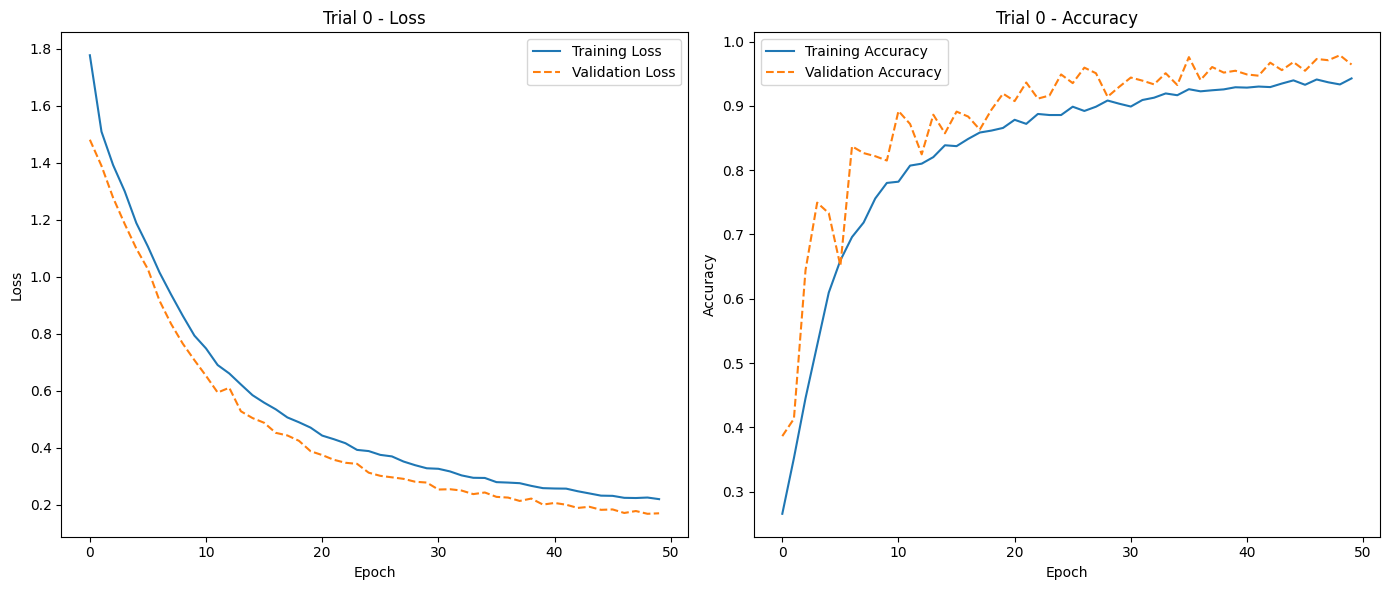

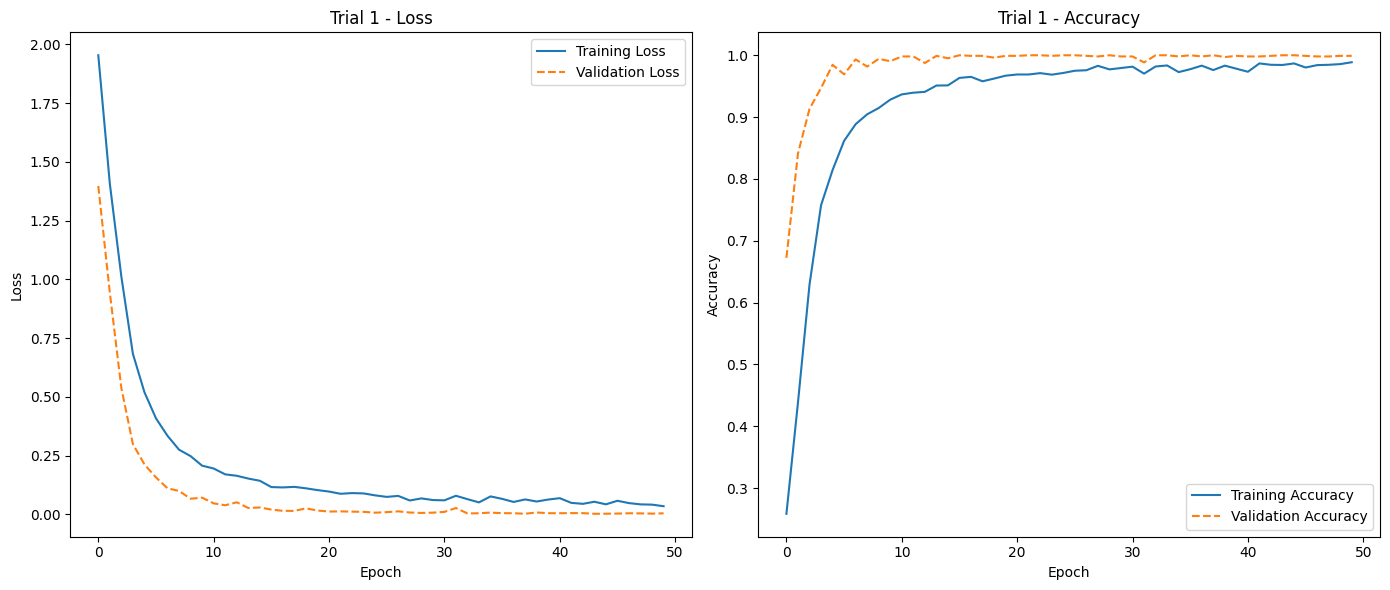

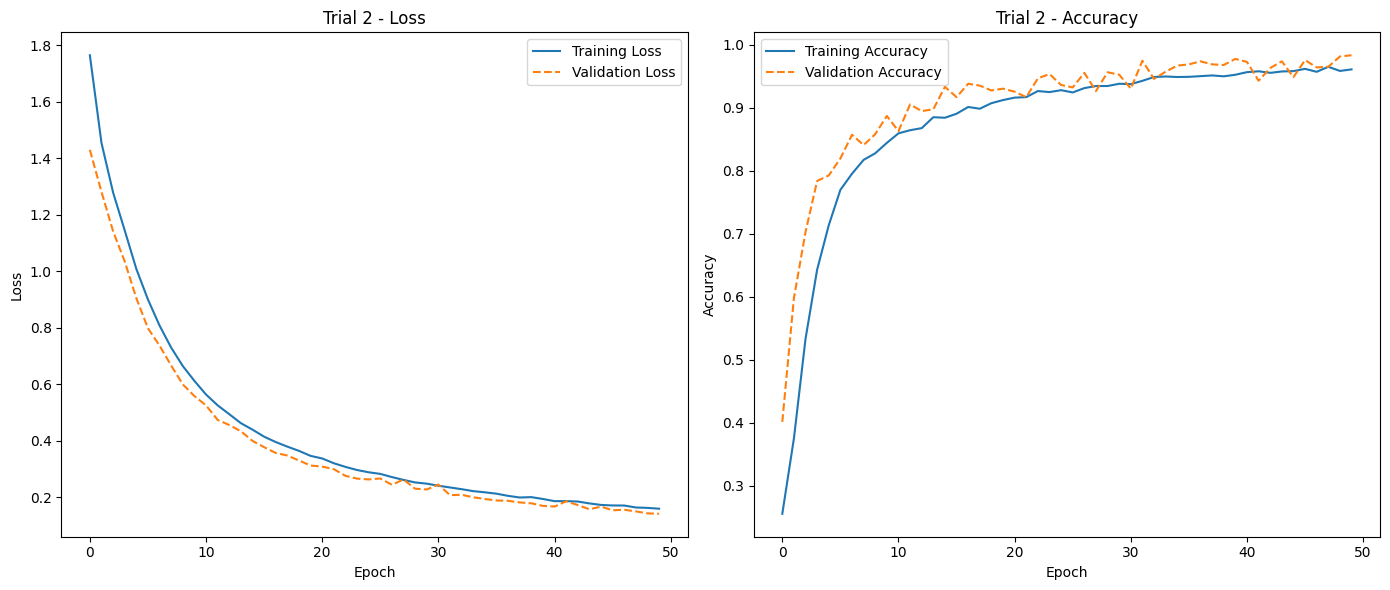

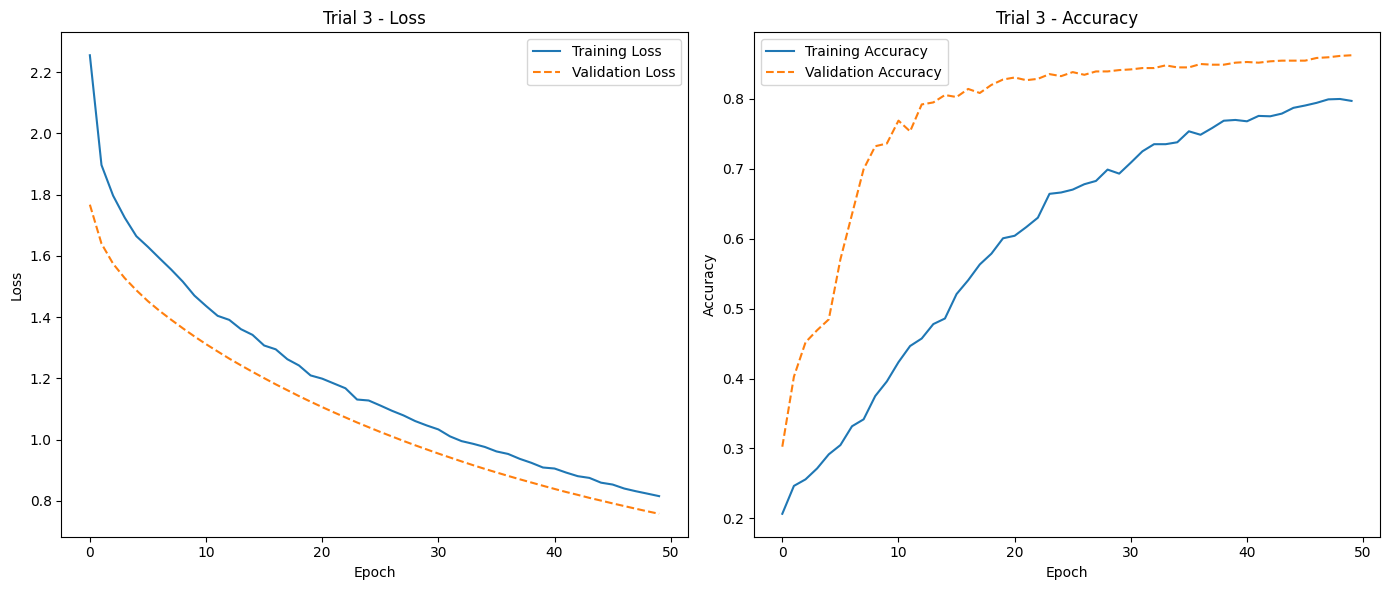

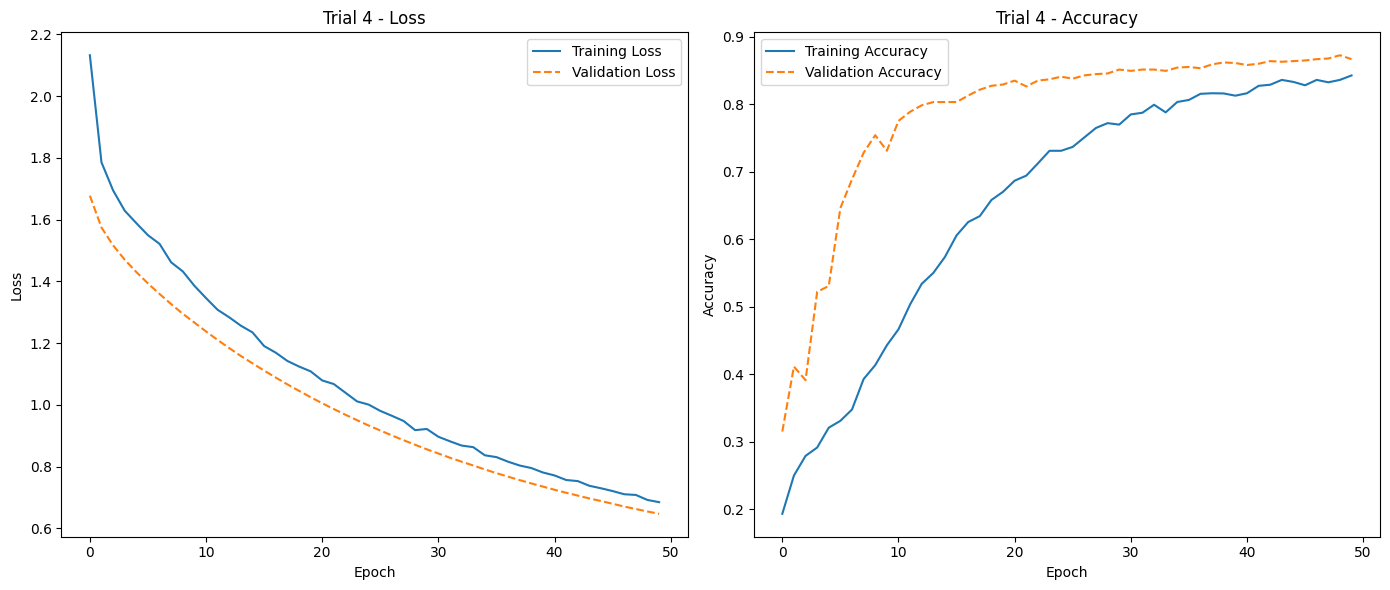

In [11]:
import matplotlib.pyplot as plt
import os

os.makedirs("vgg_optuna_plots", exist_ok=True)

for trial in study.trials:
    history = trial.user_attrs.get("history")
    if history:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot Loss
        axs[0].plot(history["loss"], label="Training Loss")
        axs[0].plot(history["val_loss"], linestyle='--', label="Validation Loss")
        axs[0].set_title(f"Trial {trial.number} - Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        # Plot Accuracy
        axs[1].plot(history["accuracy"], label="Training Accuracy")
        axs[1].plot(history["val_accuracy"], linestyle='--', label="Validation Accuracy")
        axs[1].set_title(f"Trial {trial.number} - Accuracy")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Accuracy")
        axs[1].legend()

        plt.tight_layout()
        plt.savefig(f"vgg_optuna_plots/vgg16_trial_{trial.number}_plot.png")
        plt.show()

In [9]:
import shutil
shutil.make_archive('vgg_optuna_checkpoints', 'zip', "/kaggle/working/vgg_checkpoints")


'/kaggle/working/vgg_optuna_checkpoints.zip'

In [12]:
import shutil
shutil.make_archive('vgg_optuna_plots', 'zip', "/kaggle/working/vgg_optuna_plots")


'/kaggle/working/vgg_optuna_plots.zip'